In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.impute import SimpleImputer

In [3]:
from google.colab import files
uploaded = files.upload()

Saving test_set_features.csv to test_set_features.csv
Saving training_set_features.csv to training_set_features.csv
Saving training_set_labels.csv to training_set_labels.csv


In [4]:
# Load datasets
train_f = pd.read_csv("training_set_features.csv")
train_l = pd.read_csv("training_set_labels.csv")
test = pd.read_csv("test_set_features.csv")

In [5]:
# Merge feature and label datasets
df = pd.merge(train_f, train_l, on="respondent_id")

# Exploratory Data Analysis (EDA)

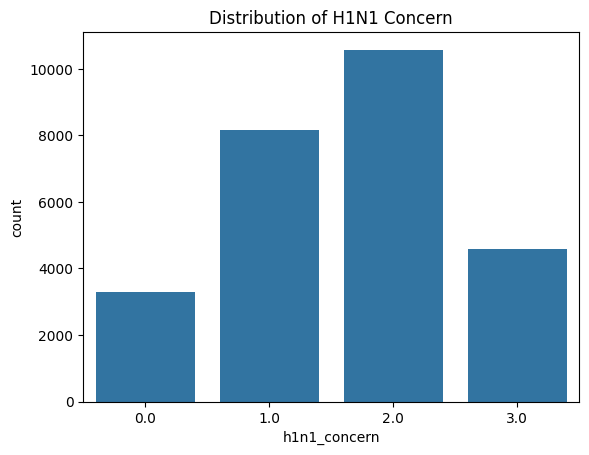

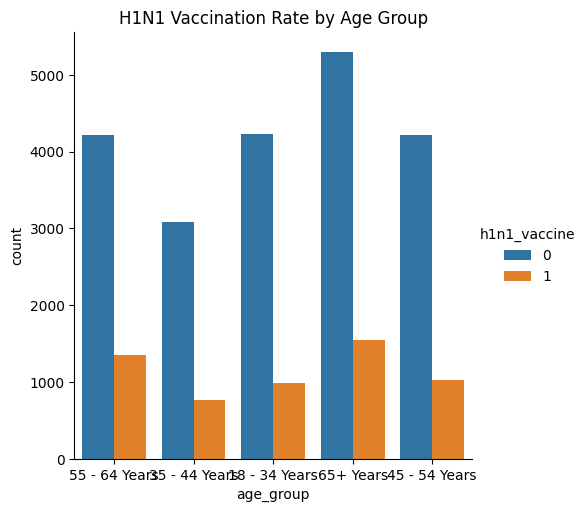

In [7]:
# 1. Visualize distributions of key features
sns.countplot(x='h1n1_concern', data=df)
plt.title("Distribution of H1N1 Concern")
plt.show()

sns.catplot(x='age_group', hue='h1n1_vaccine', data=df, kind='count')
plt.title("H1N1 Vaccination Rate by Age Group")
plt.show()

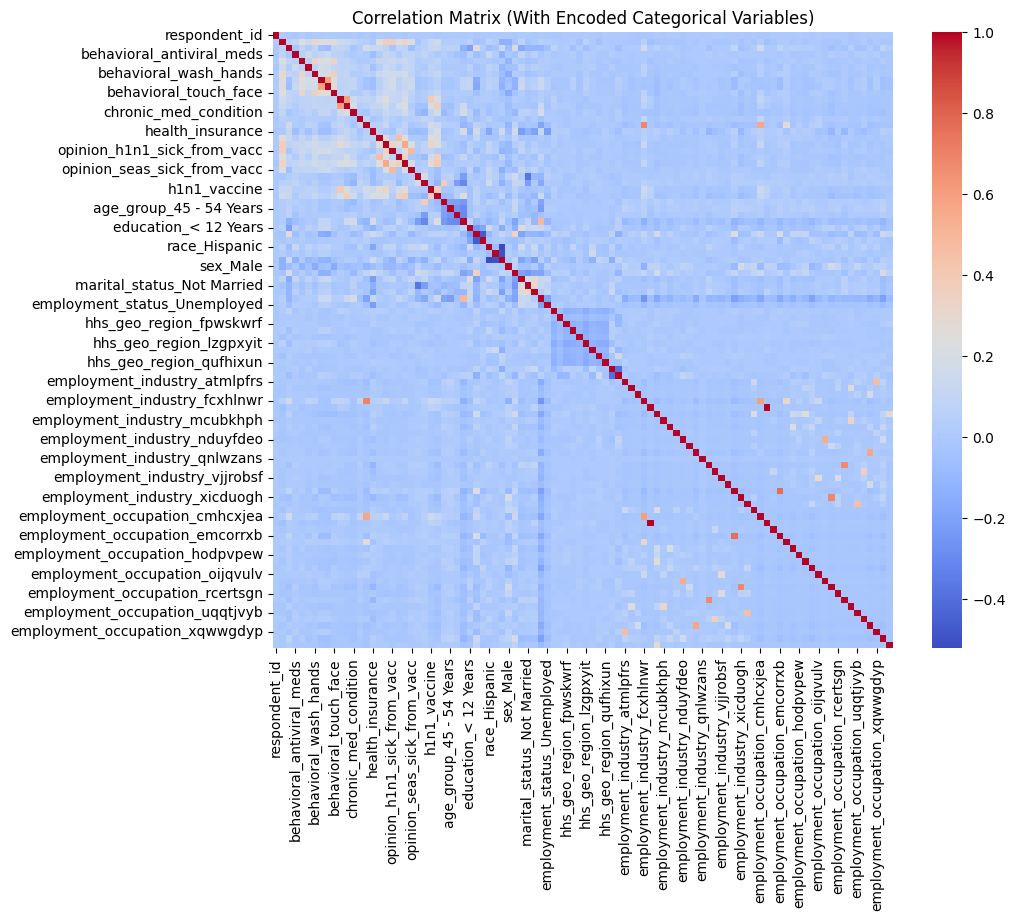

In [8]:
# Perform one-hot encoding on categorical columns
df_encoded = pd.get_dummies(df, drop_first=True)

# Compute the correlation matrix on the encoded dataframe
corr_matrix = df_encoded.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm")
plt.title("Correlation Matrix (With Encoded Categorical Variables)")
plt.show()

In [11]:
# Handle missing values: separate numeric and non-numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
categorical_cols = df.select_dtypes(exclude=[np.number]).columns

# Impute missing values in numeric columns using the median strategy
numeric_imputer = SimpleImputer(strategy='median')
df_numeric_imputed = pd.DataFrame(numeric_imputer.fit_transform(df[numeric_cols]), columns=numeric_cols)

# Impute missing values in categorical columns using the most frequent strategy
categorical_imputer = SimpleImputer(strategy='most_frequent')
df_categorical_imputed = pd.DataFrame(categorical_imputer.fit_transform(df[categorical_cols]), columns=categorical_cols)

# Combine the numeric and categorical columns back into one DataFrame
df_imputed = pd.concat([df_numeric_imputed, df_categorical_imputed], axis=1)

# Encode categorical columns using one-hot encoding
df_encoded = pd.get_dummies(df_imputed, drop_first=True)  # Drop first to avoid multicollinearity

In [12]:
# Split the data into training and test sets (80% train, 20% test)
X = df_encoded.drop(columns=['h1n1_vaccine', 'seasonal_vaccine'])  # Features
y_h1n1 = df_encoded['h1n1_vaccine']  # Target for H1N1 vaccine prediction
y_seasonal = df_encoded['seasonal_vaccine']  # Target for seasonal vaccine prediction

X_train, X_test, y_train_h1n1, y_test_h1n1 = train_test_split(X, y_h1n1, test_size=0.2, random_state=42)
X_train_seasonal, X_test_seasonal, y_train_seasonal, y_test_seasonal = train_test_split(X, y_seasonal, test_size=0.2, random_state=42)


# GLM Model (Logistic Regression in Python)


In [13]:
# Logistic Regression for H1N1 vaccine
glm_h1n1 = LogisticRegression(max_iter=1000)
glm_h1n1.fit(X_train, y_train_h1n1)
glm_h1n1_pred = glm_h1n1.predict_proba(X_test)[:, 1]

# Logistic Regression for Seasonal vaccine
glm_seasonal = LogisticRegression(max_iter=1000)
glm_seasonal.fit(X_train_seasonal, y_train_seasonal)
glm_seasonal_pred = glm_seasonal.predict_proba(X_test_seasonal)[:, 1]

# Evaluate Logistic Regression models
auc_h1n1_glm = roc_auc_score(y_test_h1n1, glm_h1n1_pred)
auc_seasonal_glm = roc_auc_score(y_test_seasonal, glm_seasonal_pred)

print(f"AUC for H1N1 (GLM): {auc_h1n1_glm}")
print(f"AUC for Seasonal (GLM): {auc_seasonal_glm}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC for H1N1 (GLM): 0.8228565245526896
AUC for Seasonal (GLM): 0.8508102284541806


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# ADA Boost Model (using AdaBoostClassifier in Python)

In [14]:
# Hyperparameter Tuning with GridSearchCV
ada_boost = AdaBoostClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1.0]
}

# Perform Grid Search for H1N1
grid_search_h1n1 = GridSearchCV(ada_boost, param_grid, cv=5, scoring='roc_auc')
grid_search_h1n1.fit(X_train, y_train_h1n1)

# Perform Grid Search for Seasonal
grid_search_seasonal = GridSearchCV(ada_boost, param_grid, cv=5, scoring='roc_auc')
grid_search_seasonal.fit(X_train_seasonal, y_train_seasonal)

# Predict on test data using the best estimator
best_ada_h1n1 = grid_search_h1n1.best_estimator_
best_ada_seasonal = grid_search_seasonal.best_estimator_

ada_h1n1_pred = best_ada_h1n1.predict_proba(X_test)[:, 1]
ada_seasonal_pred = best_ada_seasonal.predict_proba(X_test_seasonal)[:, 1]

# Evaluate the AdaBoost models
auc_h1n1_ada = roc_auc_score(y_test_h1n1, ada_h1n1_pred)
auc_seasonal_ada = roc_auc_score(y_test_seasonal, ada_seasonal_pred)

print(f"AUC for H1N1 (AdaBoost): {auc_h1n1_ada}")
print(f"AUC for Seasonal (AdaBoost): {auc_seasonal_ada}")

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

AUC for H1N1 (AdaBoost): 0.8317537755590854
AUC for Seasonal (AdaBoost): 0.8579475604942307


In [15]:
# Confusion matrix for AdaBoost
conf_matrix_h1n1 = confusion_matrix(y_test_h1n1, best_ada_h1n1.predict(X_test))
conf_matrix_seasonal = confusion_matrix(y_test_seasonal, best_ada_seasonal.predict(X_test_seasonal))

print("Confusion Matrix for H1N1 AdaBoost:")
print(conf_matrix_h1n1)
print("Confusion Matrix for Seasonal AdaBoost:")
print(conf_matrix_seasonal)

Confusion Matrix for H1N1 AdaBoost:
[[4001  211]
 [ 656  474]]
Confusion Matrix for Seasonal AdaBoost:
[[2385  506]
 [ 643 1808]]


In [16]:
# Feature Importance Plot
feature_importance_h1n1 = best_ada_h1n1.feature_importances_
feature_importance_seasonal = best_ada_seasonal.feature_importances_

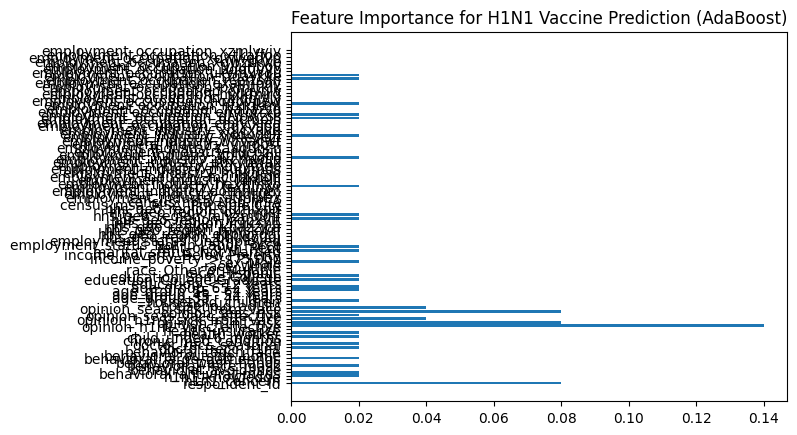

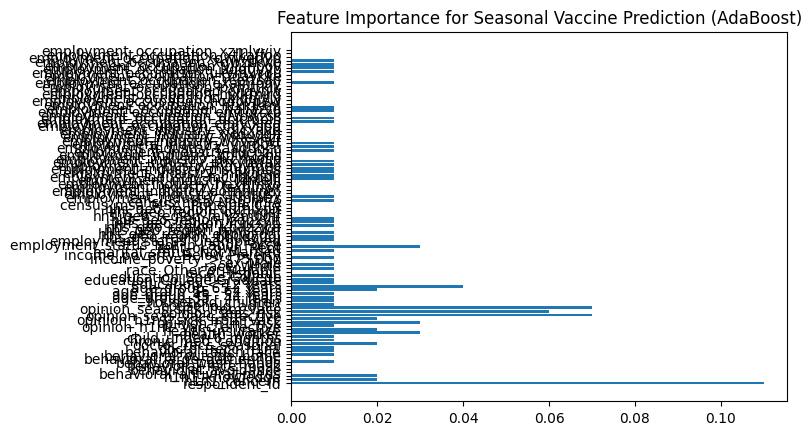

In [17]:
# Plot feature importance for H1N1
plt.barh(X.columns, feature_importance_h1n1)
plt.title("Feature Importance for H1N1 Vaccine Prediction (AdaBoost)")
plt.show()

# Plot feature importance for Seasonal
plt.barh(X.columns, feature_importance_seasonal)
plt.title("Feature Importance for Seasonal Vaccine Prediction (AdaBoost)")
plt.show()

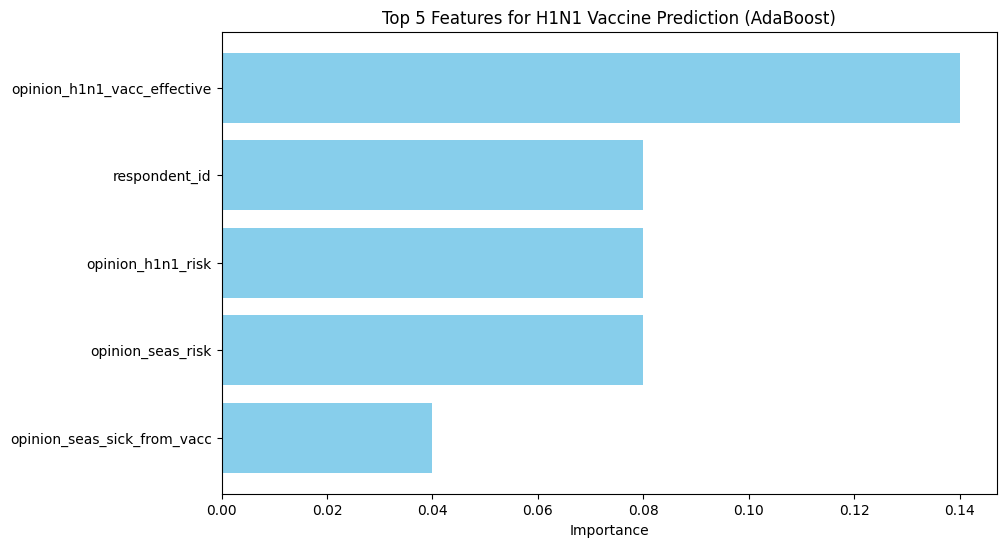

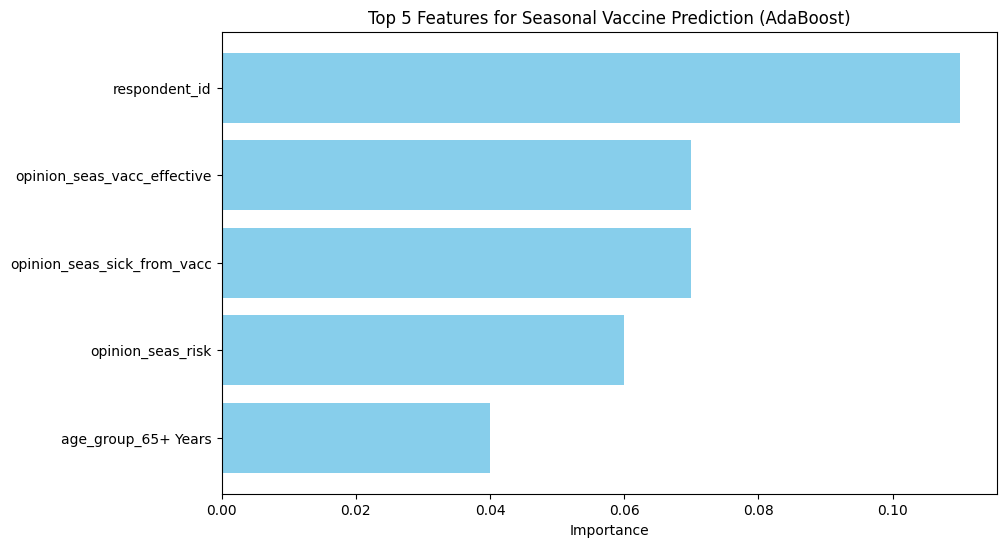

In [19]:
# Plot top 5 feature importance for H1N1
def plot_top_n_features(importance, features, n=5, title="Feature Importance"):
    # Sort the features by importance
    indices = np.argsort(importance)[-n:]  # Get the indices of the top N features
    top_features = [features[i] for i in indices]
    top_importance = importance[indices]

    # Plot the top N features
    plt.figure(figsize=(10, 6))
    plt.barh(top_features, top_importance, color='skyblue')
    plt.title(title)
    plt.xlabel("Importance")
    plt.show()

# Get the feature names
features = X.columns

# Plot top 5 features for H1N1 model
plot_top_n_features(feature_importance_h1n1, features, n=5, title="Top 5 Features for H1N1 Vaccine Prediction (AdaBoost)")

# Plot top 5 features for Seasonal model
plot_top_n_features(feature_importance_seasonal, features, n=5, title="Top 5 Features for Seasonal Vaccine Prediction (AdaBoost)")
